In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# Loading the dataset and displaying first 5 elements
df = pd.read_csv('data.csv', delimiter=";")
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


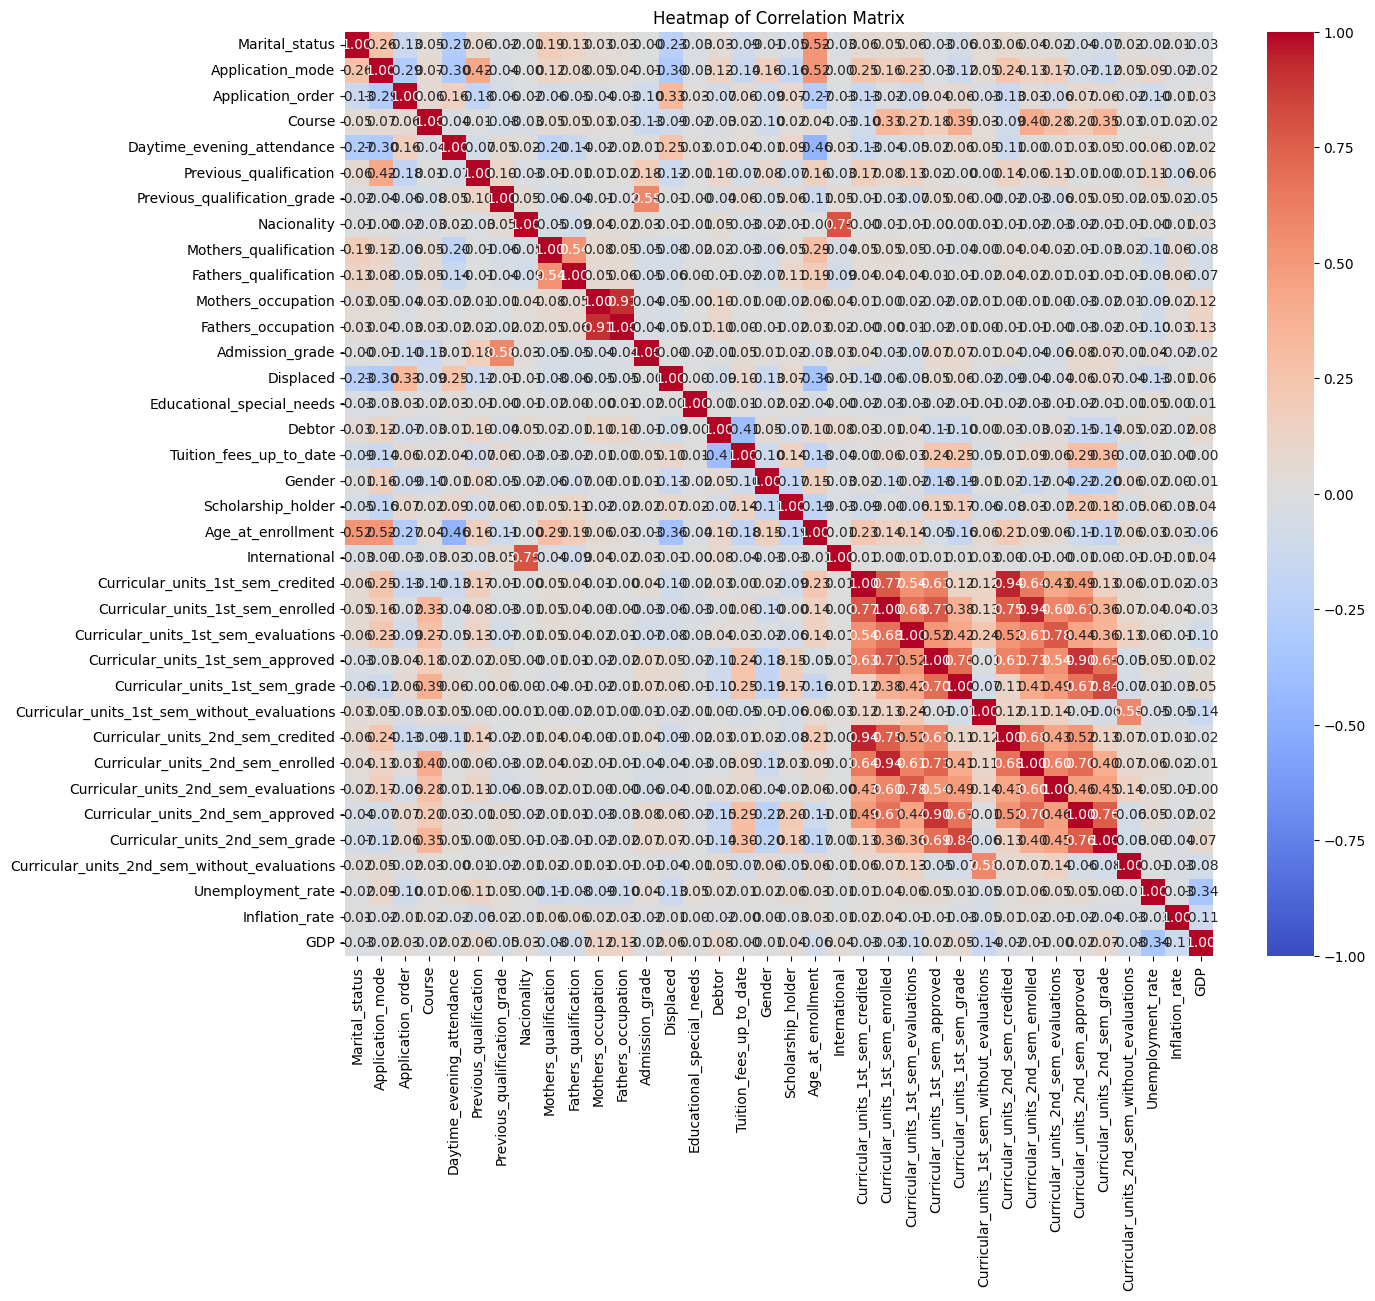

In [3]:
# Removing non-numerics to display correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(14, 12))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

After assessing the heatmap, we can narrow down our input features to the following columns, whihc might have greater effect on the model prediction than others.

In [4]:

columns_to_keep = [
    'Marital_status',
    'Application_mode',
    'Application_order',
    'Course',
    'Daytime_evening_attendance',
    'Previous_qualification',
    'Previous_qualification_grade',
    'Nacionality',
    'Mothers_qualification',
    'Fathers_qualification',
    'Mothers_occupation',
    'Fathers_occupation',
    'Admission_grade',
    'Displaced',
    'Educational_special_needs',
    'Debtor',
    'Tuition_fees_up_to_date',
    'Gender',
    'Scholarship_holder',
    'Age_at_enrollment',
    'International',
    'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved',
    'Status'
]
df = df[columns_to_keep]

Mapping ,applying standard scaler and one hot encodings on boolean columns, numerical columns, categorical columns respectively.

In [5]:

boolean_columns = {
    'Daytime_evening_attendance': {1: True, 0: False},
    'Displaced': {1: True, 0: False},
    'Educational_special_needs': {1: True, 0: False},
    'Debtor': {1: True, 0: False},
    'Tuition_fees_up_to_date': {1: True, 0: False},
    'Gender': {1: True, 0: False},
    'Scholarship_holder': {1: True, 0: False},
    'International': {1: True, 0: False},
}

for column, mapping in boolean_columns.items():
    df[column] = df[column].map(mapping)


categorical_columns = [
    'Application_mode',
    'Course',
    'Marital_status',
    'Nacionality',
    'Mothers_qualification',
    'Fathers_qualification',
    'Mothers_occupation',
    'Fathers_occupation'
]

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_columns = encoder.fit_transform(df[categorical_columns])

encoded_columns_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

df = pd.concat([df.drop(columns=categorical_columns), encoded_columns_df], axis=1)

numerical_columns = [
    'Previous_qualification_grade',
    'Admission_grade',
    'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved',
    'Age_at_enrollment'
]

scaler = StandardScaler()

df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

Enumerating the target variables, dropouts:0 and enrolled, graduates:1

In [6]:

df['Status_encoded'] = df['Status'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 2})
# Define features (X) and target (y)
X = df.drop(columns=['Status', 'Status_encoded'])  # Drop original and encoded status
y = df['Status_encoded']  # Target variable

# Encode the target variable as binary: Dropout (1) vs Others (0)
y_binary = (y == 0).astype(int)  # Assuming 0 represents 'Dropout'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3539, 212) (885, 212) (3539,) (885,)


In [7]:
# Initialize the One-vs-Rest Random Forest model
ovr_rf = OneVsRestClassifier(RandomForestClassifier(random_state=42))

# Train the model
ovr_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = ovr_rf.predict(X_test)

# Evaluate the model
print("Random Forest Evaluation for Dropout Prediction")

# Display accuracy as a percentage with 1 decimal place
accuracy = accuracy_score(y_test, y_pred_rf) * 100
print(f"Accuracy: {accuracy:.1f}%")

# Display the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Evaluation for Dropout Prediction
Accuracy: 73.6%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       316
           1       0.73      0.94      0.82       418
           2       0.45      0.17      0.24       151

    accuracy                           0.74       885
   macro avg       0.66      0.61      0.61       885
weighted avg       0.71      0.74      0.70       885



Finding out the top 10 features that effect the model predictions to further train it for better accuracy

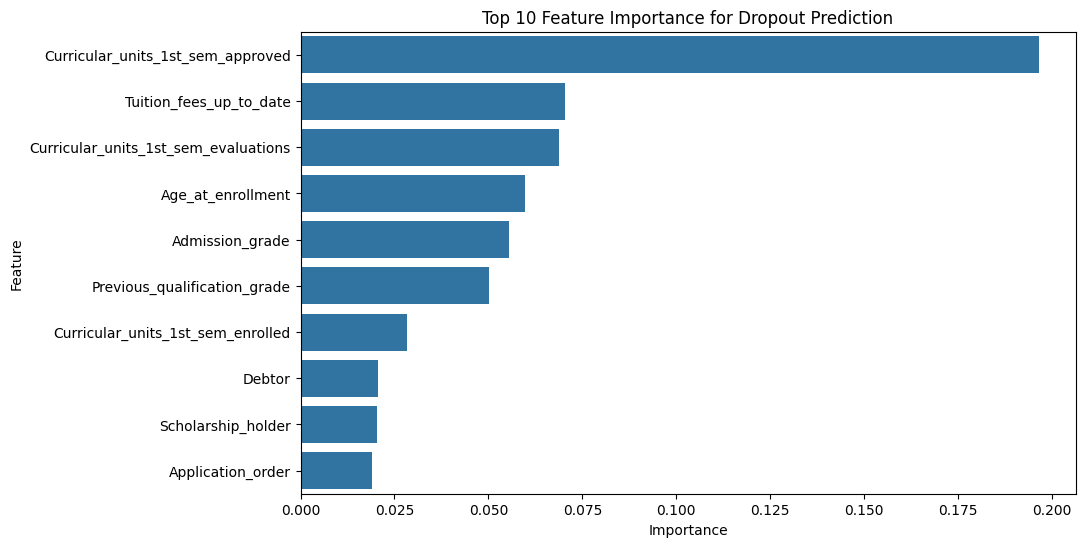

In [8]:
# Get feature importance from the model (for the 'Dropout' class)
feature_importances = ovr_rf.estimators_[0].feature_importances_

# Create a DataFrame for visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance and select the top 10 features
top_10_importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_importance_df)
plt.title('Top 10 Feature Importance for Dropout Prediction')
plt.show()

Final Model training , evaluation by using top 10 input features

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('data.csv', delimiter=";")

# Feature selection
selected_features = [
    'Curricular_units_1st_sem_approved',
    'Age_at_enrollment',
    'Admission_grade',
    'Curricular_units_1st_sem_evaluations',
    'Previous_qualification_grade',
    'Tuition_fees_up_to_date',
    'Application_order',
    'Curricular_units_1st_sem_enrolled',
    'Gender',
    'Mothers_qualification'
]
X = data[selected_features]

# Encode target variable (Map Dropout=0, Enrolled=1, Graduate=1)
data['Status_encoded'] = data['Status'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
y = data['Status_encoded']

# Balance dataset using SMOTE (for binary classification)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize and train Random Forest model for binary classification
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Graduate/Enrolled)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")


Accuracy: 0.8585690515806988
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       586
           1       0.84      0.89      0.87       616

    accuracy                           0.86      1202
   macro avg       0.86      0.86      0.86      1202
weighted avg       0.86      0.86      0.86      1202

Confusion Matrix:
[[481 105]
 [ 65 551]]
ROC-AUC Score: 0.9232635964717876
